### de proch en proch avec regle sur les substituant 

In [1]:
import json
import random
from datetime import datetime

# Liste des substituants disponibles
SUBSTITUANTS = [
    "H",
    "NH2",
    "NO2",
    "CHO",
    "CN",
    "OH",
    "F",
    "CH3",
    "CHCH2"
]

# Règles de transition : dictionnaire {substituant_actuel: [substituants_autorisés]}
# Si un substituant n'est pas dans le dictionnaire, tous les autres sont autorisés
# NH2 < OH < CH3 < CH=CH2 < H < F < CHO < CN < NO2
REGLES_TRANSITION = {
    "NH2": ["OH"],
    "OH": ["CH3", "NH2"],
    "CH3": ["CHCH2" , "OH"],
    "CHCH2": ["H" , "CH3"],
    "H": ["F" , "CHCH2"],
    "F": ["CHO" , "H"],
    "CHO": ["CN" , "F"],
    "CN": ["NO2", "CHO"],
    "NO2": ["CN"] 
}

def obtenir_substituants_autorises(substituant_actuel):
    """Retourne la liste des substituants autorisés depuis un substituant donné"""
    if substituant_actuel in REGLES_TRANSITION:
        # Utiliser les règles définies
        return REGLES_TRANSITION[substituant_actuel]
    else:
        # Si pas de règle, tous les autres substituants sont autorisés
        return [s for s in SUBSTITUANTS if s != substituant_actuel]

def charger_donnees(fichier):
    """Charge les données depuis le fichier JSON"""
    with open(fichier, 'r') as f:
        return json.load(f)

def generer_rotations(substituants):
    """Génère toutes les rotations possibles d'une configuration"""
    rotations = []
    n = len(substituants)
    for i in range(n):
        rotations.append(substituants[i:] + substituants[:i])
    return rotations

def generer_miroir(substituants):
    """Génère le miroir d'une configuration (inversion de l'ordre sauf position 1)"""
    return [substituants[0]] + substituants[1:][::-1]

def generer_toutes_symetries(substituants):
    """Génère toutes les configurations équivalentes (rotations + miroirs)"""
    symetries = []
    
    # Toutes les rotations
    for rotation in generer_rotations(substituants):
        symetries.append(rotation)
    
    # Miroir puis toutes ses rotations
    miroir = generer_miroir(substituants)
    for rotation in generer_rotations(miroir):
        symetries.append(rotation)
    
    return symetries

def creer_signature_canonique(substituants):
    """Crée une signature canonique unique pour toutes les formes symétriques"""
    symetries = generer_toutes_symetries(substituants)
    symetries_tuples = [tuple(s) for s in symetries]
    return min(symetries_tuples)

def construire_index_signatures(donnees):
    """Construit un dictionnaire : signature canonique -> composé"""
    index = {}
    for compose in donnees:
        substituants = [compose['Substituants_simple'][str(i+1)] for i in range(6)]
        signature = creer_signature_canonique(substituants)
        index[signature] = compose
    return index

def trouver_compose_par_signature(index, substituants):
    """Cherche un composé par sa signature canonique"""
    signature = creer_signature_canonique(substituants)
    return index.get(signature, None)

def generer_matrice_positions():
    """Génère la matrice de positions standard pour un benzène"""
    return [
        [0, 1, 2, 3, 2, 1],
        [1, 0, 1, 2, 3, 2],
        [2, 1, 0, 1, 2, 3],
        [3, 2, 1, 0, 1, 2],
        [2, 3, 2, 1, 0, 1],
        [1, 2, 3, 2, 1, 0]
    ]

def calculer_matrice_distances(substituants):
    """Calcule la matrice de distances entre substituants avec leurs labels"""
    n = len(substituants)
    distances_cycle = generer_matrice_positions()
    
    groupes = {}
    for i, sub in enumerate(substituants):
        if sub not in groupes:
            groupes[sub] = []
        groupes[sub].append(i)
    
    lignes = []
    labels = []
    
    for sub in sorted(groupes.keys()):
        for idx in groupes[sub]:
            labels.append(sub)
            ligne = []
            for sub2 in sorted(groupes.keys()):
                for idx2 in groupes[sub2]:
                    ligne.append(distances_cycle[idx][idx2])
            lignes.append(ligne)
    
    return labels, lignes

def afficher_matrice_distances_formatee(substituants):
    """Affiche la matrice de distances de manière formatée"""
    labels, matrice = calculer_matrice_distances(substituants)
    max_label_width = max(len(label) for label in labels)
    
    resultat = []
    header = " " * (max_label_width + 2)
    for label in labels:
        header += f"{label:>6}"
    resultat.append(header)
    
    for i, label in enumerate(labels):
        ligne = f"{label:>{max_label_width}}  "
        for val in matrice[i]:
            ligne += f"{val:>6}"
        resultat.append(ligne)
    
    return "\n".join(resultat)

def changer_substituant(substituants_actuels, position_fixe):
    """Change un substituant à une position fixée en respectant les règles"""
    nouvelle_config = substituants_actuels.copy()
    ancien_sub = nouvelle_config[position_fixe]
    
    # Obtenir les substituants autorisés selon les règles
    substituants_autorises = obtenir_substituants_autorises(ancien_sub)
    
    if not substituants_autorises:
        # Aucune transition autorisée
        return None, ancien_sub, None
    
    # Choisir un nouveau substituant parmi ceux autorisés
    nouveau_sub = random.choice(substituants_autorises)
    nouvelle_config[position_fixe] = nouveau_sub
    
    return nouvelle_config, ancien_sub, nouveau_sub

def afficher_regles_transition():
    """Retourne une chaîne formatée des règles de transition"""
    resultat = []
    resultat.append("Règles de transition définies:")
    for ancien, nouveaux in sorted(REGLES_TRANSITION.items()):
        resultat.append(f"  {ancien:>6} → {', '.join(nouveaux)}")
    resultat.append("\nAutres substituants: toutes transitions autorisées (sauf vers eux-mêmes)")
    return "\n".join(resultat)

def marche_aleatoire(fichier_json, nb_etapes=5, max_essais=100):
    """Effectue une marche aléatoire dans l'espace des composés"""
    
    # Charger les données et construire l'index
    donnees = charger_donnees(fichier_json)
    index_signatures = construire_index_signatures(donnees)
    
    print(f"Index créé avec {len(index_signatures)} signatures uniques")
    
    # Composé de départ : benzène (tous H)
    substituants_actuels = ["H", "H", "H", "H", "H", "H"]
    
    # Ouvrir le fichier de sortie
    with open('marche_aleatoire.txt', 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("MARCHE ALÉATOIRE - COMPOSÉS BENZÉNIQUES (avec règles de transition)\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Nombre d'étapes: {nb_etapes}\n")
        f.write("=" * 80 + "\n\n")
        
        # Afficher les règles
        f.write(afficher_regles_transition())
        f.write("\n\n")
        f.write("=" * 80 + "\n\n")
        
        # Étape 0 : Composé de départ
        f.write("ÉTAPE 0 - COMPOSÉ DE DÉPART\n")
        f.write("-" * 80 + "\n")
        compose_depart = trouver_compose_par_signature(index_signatures, substituants_actuels)
        
        if compose_depart:
            f.write(f"SMILES: {compose_depart['SMILES']}\n")
            f.write(f"Fichier: {compose_depart['Fichier']}\n")
            f.write(f"Substituants (forme trouvée): {[compose_depart['Substituants_simple'][str(i+1)] for i in range(6)]}\n")
        else:
            f.write("Composé: Benzène (non calculé dans les données)\n")
        
        f.write(f"Substituants (forme demandée): {substituants_actuels}\n")
        f.write("Positions: 1=H, 2=H, 3=H, 4=H, 5=H, 6=H\n")
        
        if compose_depart and 'Energies' in compose_depart:
            energies = compose_depart['Energies']
            f.write(f"\nÉnergies:\n")
            f.write(f"  HOMO: {energies['HOMO_Ha']:.5f} Ha\n")
            f.write(f"  LUMO: {energies['LUMO_Ha']:.5f} Ha\n")
            f.write(f"  GAP:  {energies['GAP_eV']:.6f} eV\n")
        
        f.write("\nMatrice des distances entre substituants:\n")
        f.write(afficher_matrice_distances_formatee(substituants_actuels))
        f.write("\n\n\n")
        
        # Effectuer les étapes de la marche aléatoire
        for etape in range(1, nb_etapes + 1):
            f.write(f"ÉTAPE {etape}\n")
            f.write("-" * 80 + "\n")
            
            trouve = False
            positions_essayees = []
            essais_par_position = {}
            transitions_interdites = []
            
            # Essayer différentes positions si nécessaire
            while not trouve and len(positions_essayees) < 6:
                positions_disponibles = [i for i in range(6) if i not in positions_essayees]
                if not positions_disponibles:
                    break
                
                position_a_changer = random.choice(positions_disponibles)
                positions_essayees.append(position_a_changer)
                
                ancien_sub = substituants_actuels[position_a_changer]
                substituants_autorises = obtenir_substituants_autorises(ancien_sub)
                
                f.write(f"Position choisie pour changement: {position_a_changer + 1}\n")
                f.write(f"Substituant actuel: {ancien_sub}\n")
                f.write(f"Transitions autorisées: {', '.join(substituants_autorises)}\n")
                
                # Essais de substituants pour cette position
                essais = 0
                tentatives_substituants = []
                substituants_testes = set()
                
                while not trouve and len(substituants_testes) < len(substituants_autorises):
                    essais += 1
                    resultat = changer_substituant(substituants_actuels, position_a_changer)
                    
                    if resultat[0] is None:
                        # Aucune transition autorisée
                        f.write(f"  ✗ Aucune transition autorisée depuis {ancien_sub}\n")
                        break
                    
                    nouvelle_config, ancien, nouveau = resultat
                    substituants_testes.add(nouveau)
                    tentatives_substituants.append(nouveau)
                    compose = trouver_compose_par_signature(index_signatures, nouvelle_config)
                    
                    if compose:
                        trouve = True
                        substituants_actuels = nouvelle_config
                        
                        f.write(f"  ✓ Succès après {essais} essai(s)\n")
                        f.write(f"  Changement: Position {position_a_changer+1} : {ancien} → {nouveau}\n")
                        if essais > 1:
                            f.write(f"  Substituants testés: {', '.join(tentatives_substituants)}\n")
                        f.write("\n")
                        
                        forme_trouvee = [compose['Substituants_simple'][str(i+1)] for i in range(6)]
                        
                        f.write(f"SMILES: {compose['SMILES']}\n")
                        f.write(f"Fichier: {compose['Fichier']}\n")
                        f.write(f"Substituants (forme demandée): {substituants_actuels}\n")
                        if forme_trouvee != substituants_actuels:
                            f.write(f"Substituants (forme trouvée):  {forme_trouvee}\n")
                            f.write(f"  → Configurations équivalentes par symétrie du benzène\n")
                        
                        positions_str = ", ".join([f"{i+1}={sub}" for i, sub in enumerate(substituants_actuels)])
                        f.write(f"Positions: {positions_str}\n")
                        
                        if 'Energies' in compose:
                            energies = compose['Energies']
                            f.write(f"\nÉnergies:\n")
                            f.write(f"  HOMO: {energies['HOMO_Ha']:.5f} Ha\n")
                            f.write(f"  LUMO: {energies['LUMO_Ha']:.5f} Ha\n")
                            f.write(f"  GAP:  {energies['GAP_eV']:.6f} eV\n")
                        
                        f.write("\nMatrice des distances entre substituants:\n")
                        f.write(afficher_matrice_distances_formatee(substituants_actuels))
                        f.write("\n\n\n")
                
                if not trouve:
                    essais_par_position[position_a_changer + 1] = (ancien_sub, tentatives_substituants)
                    f.write(f"  ✗ Aucun composé trouvé pour position {position_a_changer + 1}\n")
                    f.write(f"  Substituants testés: {', '.join(tentatives_substituants)}\n")
                    f.write(f"  → Changement de position...\n\n")
            
            if not trouve:
                f.write(f"ATTENTION: Aucun composé trouvé après avoir testé {len(positions_essayees)} position(s)!\n")
                f.write(f"Positions testées: {[p+1 for p in positions_essayees]}\n")
                for pos, (ancien, subs) in essais_par_position.items():
                    f.write(f"  Position {pos} ({ancien}): {', '.join(subs)}\n")
                f.write("La marche aléatoire s'arrête ici.\n\n")
                break
        
        f.write("=" * 80 + "\n")
        f.write("FIN DE LA MARCHE ALÉATOIRE\n")
        f.write("=" * 80 + "\n")
    
    print(f"Marche aléatoire terminée ! Résultats dans 'marche_aleatoire.txt'")

# Exécution
if __name__ == "__main__":
    marche_aleatoire("analyse_matrices.json", nb_etapes=300, max_essais=100)

Index créé avec 23660 signatures uniques
Marche aléatoire terminée ! Résultats dans 'marche_aleatoire.txt'


## annalyser les resultat de la marche aleatoire

### raport avec donner complete

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.backends.backend_pdf import PdfPages

# ==============================================================
# 1. Lecture du fichier et extraction des HOMO, LUMO, GAP
# ==============================================================

def parse_marche(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        content = f.read()

    # Recherche des énergies
    pattern = r"HOMO:\s*([-+]?\d*\.\d+|\d+)\s*Ha\s*LUMO:\s*([-+]?\d*\.\d+|\d+)\s*Ha\s*GAP:\s*([-+]?\d*\.\d+|\d+)\s*eV"
    data = re.findall(pattern, content)

    homo = np.array([float(x[0]) * 27.2114 for x in data])
    lumo = np.array([float(x[1]) * 27.2114 for x in data])
    gap  = np.array([float(x[2]) for x in data])
    return homo, lumo, gap


# ==============================================================
# 2. Outils mathématiques
# ==============================================================

def fitness_auto_correlation(fitnesses: list[float], max_lag: int) -> list[float]:
    """
    Calcule les coefficients d'auto-corrélation d'une liste de valeurs fitness.
    """
    auto_correlations: list[float] = []
    for l in range(1, max_lag):
        auto_correlations.append(float(np.corrcoef(fitnesses[:-l], fitnesses[l:])[0, 1]))
    return auto_correlations


def correlation_length(C, threshold= 0.15):
    """
    Estimation robuste de Lc : premier lag où C(k) tombe en dessous du seuil.
    """
    C = np.array(C)
    for i, val in enumerate(C, start=1):
        if val < threshold:
            return i
    return len(C)


def delta_fitness(f):
    return np.diff(f)


def fitness_stats(dF, threshold=1e-3):
    inc = np.sum(dF > threshold)
    dec = np.sum(dF < -threshold)
    neutre = np.sum(np.abs(dF) <= threshold)
    total = len(dF)
    return inc/total, neutre/total, dec/total


# ============================
# 3. Analyse et sauvegarde txt + PDF
# ============================
def analyze_fitness(name, f, txt_file, pdf):
    C = fitness_auto_correlation(f , max_lag=50)
    Lcorr = correlation_length(C)
    dF = delta_fitness(f)
    inc, neutre, dec = fitness_stats(dF)

    txt_file.write(f"\n=== Analyse for {name} ===\n")
    txt_file.write(f"Correlation length : {Lcorr:.2f}\n")
    txt_file.write(f"Increasing step : {inc*100:.1f}%, Neutral : {neutre*100:.1f}%, Decreasing : {dec*100:.1f}%\n")
    txt_file.write(f"Mean Δfitness: {np.mean(np.abs(dF)):.4f}\n")

    # Graphiques
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    axs[0].plot(f)
    axs[0].set_title(f"{name} - evolution")
    axs[0].set_xlabel("step")
    axs[0].set_ylabel(name)

    axs[1].plot(np.arange(1, len(C)+1), C)
    axs[1].set_title(f"{name} Autocorrelation")
    axs[1].set_xlabel("Lag k")
    axs[1].set_ylabel("C(k)")

    axs[2].hist(dF, bins=15, alpha=0.7)
    axs[2].set_title(f"Distribution of Δ{name}")
    axs[2].set_xlabel("Δfitness")
    axs[2].set_ylabel("Frequency")

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

    return {
        "name": name,
        "Lcorr": Lcorr,
        "inc": inc,
        "neutre": neutre,
        "dec": dec,
        "mean_dF": np.mean(np.abs(dF))
    }


# ============================
# 4. Exécution
# ============================
if __name__ == "__main__":
    homo, lumo, gap = parse_marche("marche_aleatoire.txt")

    results = []
    with open("Data_Landscape.txt", "w", encoding="utf-8") as txt_file, \
         PdfPages("Data_Landscape.pdf") as pdf:
        results.append(analyze_fitness("HOMO", homo, txt_file, pdf))
        results.append(analyze_fitness("LUMO", lumo, txt_file, pdf))
        results.append(analyze_fitness("GAP", gap, txt_file, pdf))

        # Résumé global
        txt_file.write("\n=== RÉSUMÉ GLOBAL ===\n")
        for r in results:
            txt_file.write(f"{r['name']}: Lc={r['Lcorr']:.2f}, Δmoy={r['mean_dF']:.4f}\n")

    print("Analyse complète enregistrée dans 'Data_Landscape.txt' et 'Data_Landscape.pdf'.")



Analyse complète enregistrée dans 'Data_Landscape.txt' et 'Data_Landscape.pdf'.


### affichage de tout les resultat

Lecture du fichier 'marche_aleatoire.txt'...
Données extraites pour 301 étapes.
Graphique sauvegardé sous : 'evolution_energies.png'


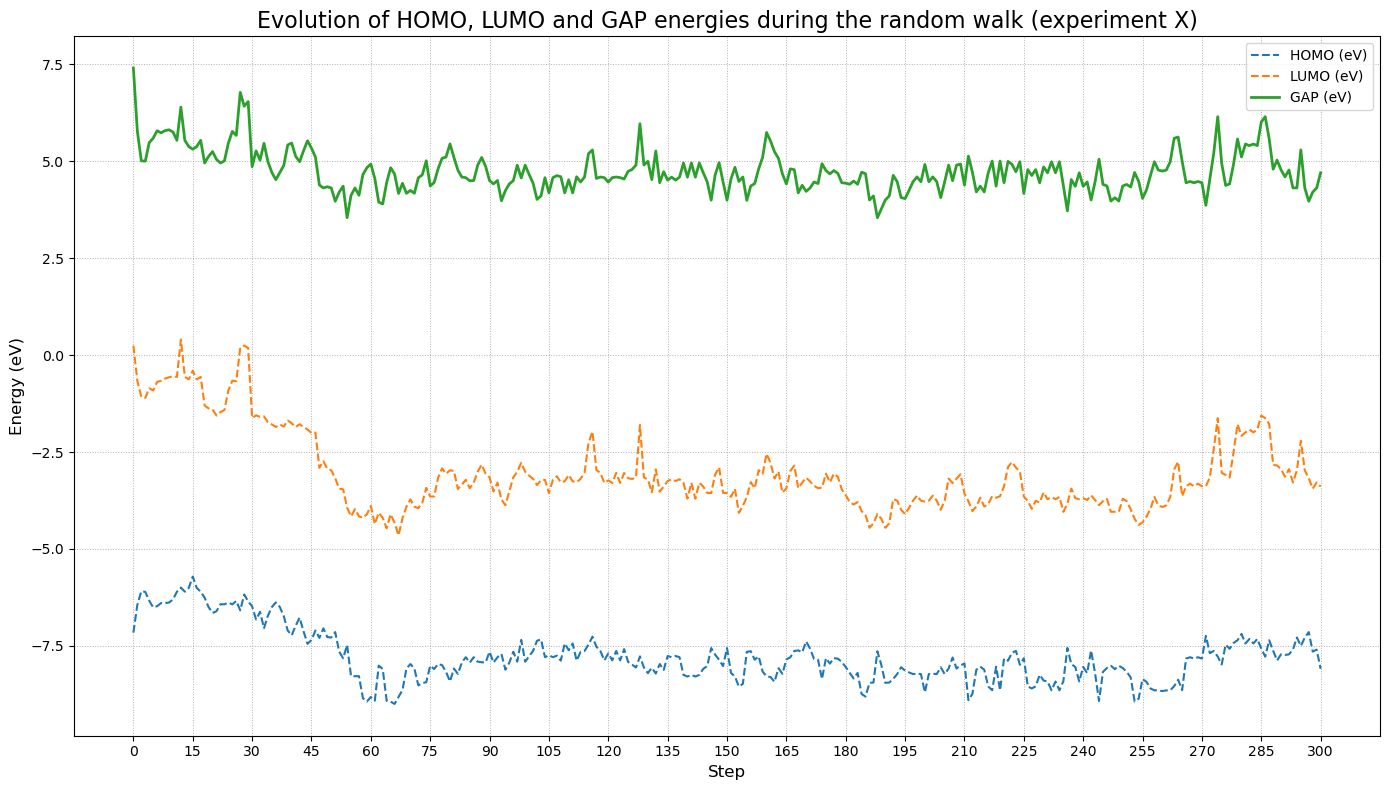

In [3]:
import matplotlib.pyplot as plt
import re
import os

# --- Configuration ---

# Nom du fichier d'entrée
NOM_FICHIER_INPUT = 'marche_aleatoire.txt'

# Nom du fichier image de sortie
NOM_FICHIER_OUTPUT = 'evolution_energies.png'

# Constante de conversion Hartree vers eV
HARTREE_TO_EV = 27.211386

# --- Initialisation des listes pour stocker les données ---
etapes = []
homo_energies_ev = []
lumo_energies_ev = []
gap_energies_ev = []

# --- Compilation des expressions régulières pour l'efficacité ---
# Regex pour trouver le numéro de l'étape
re_etape = re.compile(r"^\s*ÉTAPE (\d+)")

# Regex pour trouver l'énergie HOMO (en Ha)
re_homo = re.compile(r"^\s*HOMO:\s+(-?\d+\.\d+)\s+Ha")

# Regex pour trouver l'énergie LUMO (en Ha)
re_lumo = re.compile(r"^\s*LUMO:\s+(-?\d+\.\d+)\s+Ha")

# Regex pour trouver le GAP (déjà en eV)
re_gap = re.compile(r"^\s*GAP:\s+(-?\d+\.\d+)\s+eV")

# --- Traitement du fichier ---

# Vérifier si le fichier existe
if not os.path.exists(NOM_FICHIER_INPUT):
    print(f"Erreur : Le fichier '{NOM_FICHIER_INPUT}' n'a pas été trouvé.")
    print("Veuillez placer ce script dans le même dossier que votre fichier de données.")
else:
    print(f"Lecture du fichier '{NOM_FICHIER_INPUT}'...")
    
    # Ouvrir et lire le fichier ligne par ligne
    with open(NOM_FICHIER_INPUT, 'r', encoding='utf-8') as f:
        for line in f:
            
            # Chercher le numéro de l'étape
            match_etape = re_etape.search(line)
            if match_etape:
                etapes.append(int(match_etape.group(1)))
                continue # Passer à la ligne suivante

            # Chercher l'énergie HOMO
            match_homo = re_homo.search(line)
            if match_homo:
                homo_ha = float(match_homo.group(1))
                # Convertir en eV et stocker
                homo_energies_ev.append(homo_ha * HARTREE_TO_EV)
                continue

            # Chercher l'énergie LUMO
            match_lumo = re_lumo.search(line)
            if match_lumo:
                lumo_ha = float(match_lumo.group(1))
                # Convertir en eV et stocker
                lumo_energies_ev.append(lumo_ha * HARTREE_TO_EV)
                continue

            # Chercher le GAP
            match_gap = re_gap.search(line)
            if match_gap:
                # Le GAP est déjà en eV
                gap_energies_ev.append(float(match_gap.group(1)))
                continue

    print(f"Données extraites pour {len(etapes)} étapes.")

    # --- Génération du graphique ---
    if etapes and homo_energies_ev and lumo_energies_ev and gap_energies_ev:
        
        # S'assurer qu'on a le même nombre de points pour chaque série
        min_len = min(len(etapes), len(homo_energies_ev), len(lumo_energies_ev), len(gap_energies_ev))
        
        etapes = etapes[:min_len]
        homo_energies_ev = homo_energies_ev[:min_len]
        lumo_energies_ev = lumo_energies_ev[:min_len]
        gap_energies_ev = gap_energies_ev[:min_len]

        
        plt.figure(figsize=(14, 8)) # Définir la taille du graphique

        # Tracer chaque série de données
        plt.plot(etapes, homo_energies_ev,  linestyle='--', label='HOMO (eV)')
        plt.plot(etapes, lumo_energies_ev,  linestyle='--', label='LUMO (eV)')
        plt.plot(etapes, gap_energies_ev,  linestyle='-', label='GAP (eV)', linewidth=2)

        # Ajouter les titres et étiquettes
        plt.title("Evolution of HOMO, LUMO and GAP energies during the random walk (experiment X)", fontsize=16)
        plt.xlabel("Step", fontsize=12)
        plt.ylabel("Energy (eV)", fontsize=12)

        # Ajouter une légende
        plt.legend()

        # Ajouter une grille pour une meilleure lisibilité
        plt.grid(True, which='both', linestyle=':', linewidth=0.7)

        # Gérer l'affichage des ticks sur l'axe X (surtout s'il y a 200 étapes)
        if len(etapes) > 50:
            # Afficher un tick toutes les N étapes pour éviter la surcharge
            tick_spacing = max(1, len(etapes) // 20) # Viser ~20 ticks
            plt.xticks(etapes[::tick_spacing])
        else:
            plt.xticks(etapes) # Afficher toutes les étapes si elles sont peu nombreuses

        plt.tight_layout() # Ajuster le graphique pour éviter les superpositions

        # Sauvegarder le graphique dans un fichier
        plt.savefig(NOM_FICHIER_OUTPUT)
        print(f"Graphique sauvegardé sous : '{NOM_FICHIER_OUTPUT}'")

        # Afficher le graphique
        plt.show()

    else:
        print("Erreur : Aucune donnée complète n'a été trouvée. Vérifiez le format du fichier.")